# Подготовка данных

In [1]:
import gdown
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [2]:
gdown.download('https://drive.google.com/uc?id=1aQXoz4WIF_AzvvslL4xivpvlOAf19D4S&export=download', None, quiet=True)

'Car.zip'

In [3]:
!unzip -qo "Car.zip" -d /content/

In [4]:
paths = '/content/Car'
views = os.listdir('/content/Car')

In [5]:
data_file = []
data_labels = []
i = 0
for path in views:
  view = os.listdir(paths +'/'+ path)
  for files in view:
    vv = paths + '/' + path + '/' + files
    data_file.append(vv)
    data_labels.append(i)
  i += 1

In [6]:
data_images = []
data_images_val = []
data_lab = []
data_lab_val = []
i = 0
j = 0
for file_name in data_file:
    img = Image.open(file_name).resize((128, 72))
    img_np = np.array(img)
    if i > 10:
      data_images_val.append(img_np)
      data_lab_val.append(data_labels[j])
      i = 0
    else:
      data_images.append(img_np)
      data_lab.append(data_labels[j])
    i+=1
    j+=1

x_train = np.array(data_images)
x_val = np.array(data_images_val)
y_train = np.array(data_lab)
y_val = np.array(data_lab_val)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(1041, 72, 128, 3)
(1041,)
(104, 72, 128, 3)
(104,)


# Model

## Callback

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
early_stop_callback = EarlyStopping(monitor='val_loss', patience=20)

In [8]:
# Импортируем модуль load_model из tensorflow.keras.models для загрузки модели
from tensorflow.keras.models import load_model
# Импортируем модуль LambdaCallback из tensorflow.keras.callbacks для создания кастомного коллбэка
from tensorflow.keras.callbacks import LambdaCallback
# Импортируем модуль seaborn для настройки стиля графиков
#import seaborn as sns
# Устанавливаем стиль графиков в darkgrid
#sns.set_style('darkgrid')

# Определяем ANSI-коды для цветов, которые будем использовать в выводе
CYAN = '\033[36m'
BLUE = '\033[44m'
WHITE = '\033[37;1m'
RESET = '\033[0m'

# Определяем класс Callback, который наследует от базового класса object
class Callback(object):
  """Класс для кастомного коллбэка при обучении модели."""

  # Определяем метод on_train_begin, который вызывается в начале обучения
  def on_train_begin(self, logs):
    """Метод, вызываемый в начале обучения."""
    # Печатаем заголовок с цветом CYAN и сбрасываем цвет в конце
    print(CYAN + '========= Обучение =========' + RESET)
    print('------------------------------')
    # Создаем словарь для хранения текущих значений точности на валидации по эпохам
    self.curr = {}
    # Создаем переменную для хранения лучшего значения точности на валидации
    self.best_val = 0
    # Создаем переменную для хранения пути к файлу с лучшей моделью
    self.path = 'best_model.keras'
    self.path2 = 'best_weights.keras'

    # Создаем словарь для хранения истории обучения по метрикам
    self.hs = {}
    self.hs['loss'] = [] # Список для хранения значений функции потерь на обучающей выборке по эпохам
    self.hs['val_loss'] = [] # Список для хранения значений функции потерь на валидационной выборке по эпохам
    self.hs['accuracy'] = [] # Список для хранения значений точности на обучающей выборке по эпохам
    self.hs['val_accuracy'] = [] # Список для хранения значений точности на валидационной выборке по эпохам


  # Определяем метод on_epoch_end, который вызывается в конце каждой эпохи
  def on_epoch_end(self, epoch, logs):
    """Метод, вызываемый в конце каждой эпохи."""
    # Добавляем значения метрик из аргумента logs в соответствующие списки в словаре hs
    self.hs['loss'].append(logs['loss'])
    self.hs['val_loss'].append(logs['val_loss'])
    self.hs['accuracy'].append(logs['accuracy'])
    self.hs['val_accuracy'].append(logs['val_accuracy'])
    # Округляем значение точности на валидации до четырех знаков после запятой и сохраняем его в переменной curr_val
    self.curr_val = round(logs['val_accuracy'], 4)
    # Добавляем пару ключ-значение в словарь curr, где ключ - номер эпохи, а значение - точность на валидации
    self.curr[epoch] = self.curr_val

    # Если текущее значение точности на валидации больше лучшего значения, то обновляем лучшее значение и сохраняем модель в файл по пути path
    if self.best_val < self.curr_val:
      self.best_val = self.curr_val
      model.save(self.path)
      model.save_weights(self.path2)

  # Определяем метод on_train_end, который вызывается в конце обучения
  def on_train_end(self, logs):
    """Метод, вызываемый в конце обучения."""
    # Объявляем глобальную переменную model, чтобы иметь к ней доступ извне класса
    global model
    # Загружаем лучшую модель из файла по пути path и присваиваем ее переменной model
    #model = load_model(self.path)
    model.load_weights(self.path2)
    # Проходимся по всем парам ключ-значение в словаре curr
    for key, val in self.curr.items():
      # Если значение равно максимальному значению в словаре curr, то печатаем номер эпохи и значение точности на валидации с цветом BLUE и WHITE и сбрасываем цвет в конце
      if val == max(self.curr.values()):
        print(BLUE + WHITE + 'epoch: {} val_acc: {}'.format(key+1,val) + RESET)
      # Иначе печатаем номер эпохи и значение точности на валидации без цвета
      else:
        print('epoch: {} val_accuracy: {} '.format(key+1,val))
    # Печатаем разделительную линию
    print('-------------------------------')
    # Печатаем сообщение о завершении обучения с цветом CYAN и сбрасываем цвет в конце
    print(CYAN + '====== Обучение закончено ====' + RESET)
    print('===============================')

    # Создаем фигуру с двумя подграфиками с помощью matplotlib.pyplot (импортирован как plt)
    plt.figure(2, figsize=(16,5))

    # Выбираем первый подграфик (слева)
    plt.subplot(121)
    # Задаем заголовок подграфика с текстом 'Accuracy' и параметрами fontsize и color
    plt.title('Accuracy', fontsize=18, color='grey')
    # Рисуем линию с данными из списка hs['accuracy'], меткой 'accuracy' и цветом 'blue'
    plt.plot(self.hs['accuracy'], label='accuracy')
     # Рисуем линию с данными из списка hs['val_accuracy'], меткой 'val_accuracy' и цветом 'red'
    plt.plot(self.hs['val_accuracy'], label='val_accuracy')
     # Задаем подпись оси y с текстом '% accuracy' и параметрами fontsize и color
    plt.ylabel('% accuracy', fontsize = 13, color = 'grey')
     # Задаем подпись оси x с текстом 'epoch' и параметрами fontsize и color
    plt.xlabel('epoch', fontsize = 13, color = 'grey')
     # Выводим легенду подграфика с метками линий
    plt.legend()
    plt.grid()

     # Выбираем второй подграфик (справа)
    plt.subplot(122)
     # Задаем заголовок подграфика с текстом 'Loss' и параметрами fontsize и color
    plt.title('Loss', fontsize=18, color='grey')
     # Рисуем линию с данными из списка hs['loss'], меткой 'loss' и цветом 'blue'
    plt.plot(self.hs['loss'], label='loss')
     # Рисуем линию с данными из списка hs['val_loss'], меткой 'val_loss' и цветом 'red'
    plt.plot(self.hs['val_loss'], label='val_loss')
     # Задаем подпись оси y с текстом 'error' и параметрами fontsize и color
    plt.ylabel('error', fontsize = 13, color = 'grey')
     # Задаем подпись оси x с текстом 'epoch' и параметрами fontsize и color
    plt.xlabel('epoch', fontsize = 13, color = 'grey')
     # Выводим легенду подграфика с метками линий
    plt.legend()
    plt.grid()
     # Показываем фигуру на экране
    plt.show()


# Создаем экземпляр класса Callback и присваиваем его переменной CaLL
CaLL = Callback()

# Создаем экземпляр класса LambdaCallback и присваиваем его переменной lamCB
# Передаем в конструктор методы on_train_begin, on_epoch_end и on_train_end из экземпляра CaLL
lamCB = LambdaCallback(on_train_begin = CaLL.on_train_begin,
                       on_epoch_end = CaLL.on_epoch_end,
                       on_train_end = CaLL.on_train_end)

## Model_1

In [9]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, Input, concatenate
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils

In [10]:
y_train = utils.to_categorical(y_train)
y_val = utils.to_categorical(y_val)

In [11]:
inp_1 = Input(x_train.shape[1:])
x1 = Conv2D(256, (3,3), padding='same', activation = 'relu') (inp_1)
x1 = Conv2D(256, (3,3), padding='same', activation = 'relu') (x1)
x1 = Dropout(0.35) (x1)
x1 = Conv2D(128, (3,3), padding = 'same', activation = 'relu') (x1)
x1 = Conv2D(128, (3,3), padding = 'same', activation = 'relu') (x1)
x1 = Dropout(0.35) (x1)
x1 = Conv2D(64, (3,3), padding = 'same', activation = 'relu') (x1)
x1 = Conv2D(64, (3,3), padding = 'same', activation = 'relu') (x1)
x1 = Dropout(0.35) (x1)
x1 = Conv2D(32, (3,3), padding = 'same', activation = 'relu') (x1)
x1 = Conv2D(32, (3,3), padding = 'same', activation = 'relu') (x1)
x1 = Flatten() (x1)

x2 = Flatten() (inp_1)
x2 = Dense(512, activation= 'relu') (x2)
x2 = Dropout(0.35) (x2)
x2 = Dense(256, activation = 'relu') (x2)
x2 = Dropout(0.35) (x2)
x2 = Dense(128, activation = 'relu') (x2)
x = concatenate([x1, x2])
x = Dense(1024, activation = 'relu') (x)
x = Dropout(0.25) (x)
x = Dense(512, activation = 'relu') (x)
x_out = Dense(8, activation = 'softmax') (x)

model = Model(inp_1, x_out)

========= Обучение =========
------------------------------
Epoch 1/50
33/33 [==============================] - 119s 3s/step - loss: 5.8649 - accuracy: 0.1383 - val_loss: 1.9723 - val_accuracy: 0.2115
Epoch 2/50
33/33 [==============================] - 104s 3s/step - loss: 2.4381 - accuracy: 0.2075 - val_loss: 1.9348 - val_accuracy: 0.3173
Epoch 3/50
33/33 [==============================] - 14s 434ms/step - loss: 2.0499 - accuracy: 0.2517 - val_loss: 1.9372 - val_accuracy: 0.2692
Epoch 4/50
33/33 [==============================] - 105s 3s/step - loss: 1.9083 - accuracy: 0.2891 - val_loss: 1.8680 - val_accuracy: 0.3462
Epoch 5/50
33/33 [==============================] - 112s 3s/step - loss: 1.8279 - accuracy: 0.3103 - val_loss: 1.8121 - val_accuracy: 0.4808
Epoch 6/50
33/33 [==============================] - 15s 447ms/step - loss: 1.7421 - accuracy: 0.3410 - val_loss: 1.7539 - val_accuracy: 0.3365
Epoch 7/50
33/33 [==============================] - 15s 443ms/step - loss: 1.6244 - accura

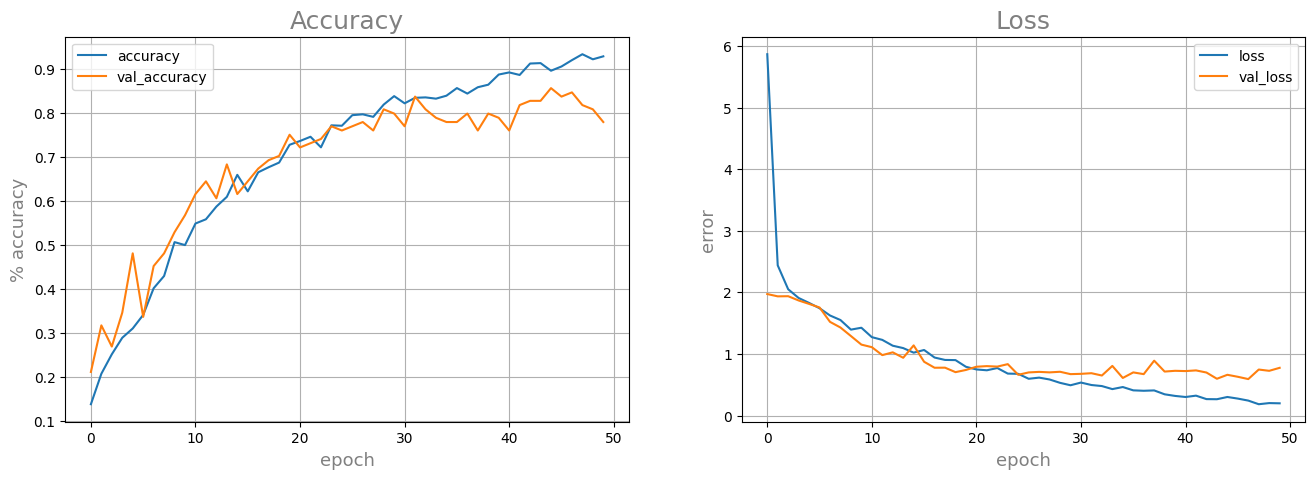

In [12]:
model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.00001))
dirgo = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 50, verbose = 1, callbacks = lamCB)

# Model_2

In [ ]:
model = Sequential()
model.add(Conv2D(256, (3,3), padding ='same', activation = 'relu', input_shape = (72, 128, 3)))
model.add(Conv2D(256, (3,3), padding = 'same', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3,3), padding = 'same', activation = 'relu'))
model.add(Conv2D(128, (3,3), padding = 'same', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Conv2D(64, (3,3), padding = 'same', activation = 'relu'))
model.add(Conv2D(64, (3,3), padding = 'same', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Conv2D(32, (3,3), padding = 'same', activation = 'relu'))
model.add(Conv2D(32, (3,3), padding = 'same', activation = 'relu'))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(8, activation = 'softmax'))


========= Обучение =========
------------------------------
Epoch 1/50
33/33 [==============================] - 123s 3s/step - loss: 47.2784 - accuracy: 0.2200 - val_loss: 1.6950 - val_accuracy: 0.4615
Epoch 2/50
33/33 [==============================] - 81s 3s/step - loss: 0.9263 - accuracy: 0.7109 - val_loss: 0.6731 - val_accuracy: 0.7885
Epoch 3/50
33/33 [==============================] - 80s 3s/step - loss: 0.2171 - accuracy: 0.9443 - val_loss: 0.5572 - val_accuracy: 0.8173
Epoch 4/50
33/33 [==============================] - 78s 2s/step - loss: 0.0982 - accuracy: 0.9866 - val_loss: 0.4600 - val_accuracy: 0.8750
Epoch 5/50
33/33 [==============================] - 6s 184ms/step - loss: 0.0264 - accuracy: 0.9942 - val_loss: 0.6141 - val_accuracy: 0.8077
Epoch 6/50
33/33 [==============================] - 6s 187ms/step - loss: 0.0072 - accuracy: 0.9990 - val_loss: 0.6198 - val_accuracy: 0.8365
Epoch 7/50
33/33 [==============================] - 6s 186ms/step - loss: 0.0013 - accuracy: 1

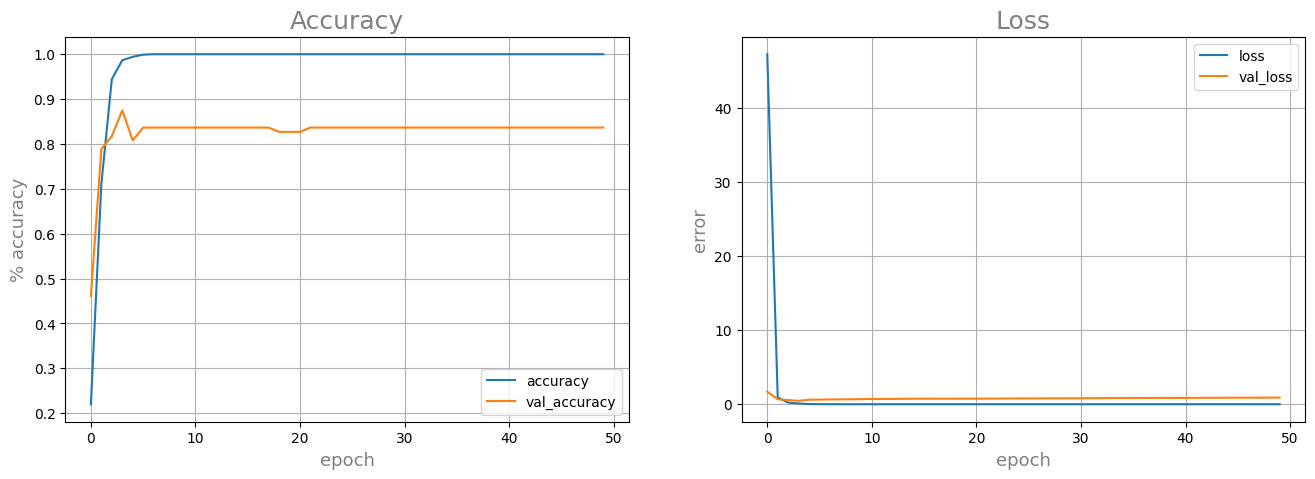

In [13]:
model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0001))
dirgo = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 50, verbose = 1, callbacks = lamCB)

In [52]:
y_pred = model.predict(x_val)
y_pred = np.array(y_pred)
v = 0
nv = 0
for i in range(y_val.shape[0]):
  pred = np.argmax(y_pred[i])
  val = np.argmax(y_val[i])
  #print(f'{np.argmax(y_pred[i])}, {np.argmax(y_val[i])}')
  if pred == val:
    v += 1
  else:
    nv += 1
print(v/y_val.shape[0])

4/4 [==============================] - 1s 100ms/step
0.9230769230769231


In [53]:
print(nv/y_val.shape[0])

0.07692307692307693
